# <center> Butter-E Dataset Notebooks: Standardization </center>
---

Note: This notebook aims to standardize the static power consumption of individual nodes. It leverages the assumption that identical experiments conducted on nodes of the same type should exhibit similar energy consumption, with the exception of a constant offset in their static power draw. To enhance optimization stability, a mild L2 regularization (lambda = 0.001) is applied to these offsets, ensuring a unique solution and preventing the proposal of excessively large offsets.


In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# add parent directory to path
sys.path.append("../")

/home/ctripp/gcomp/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# set pandas to print all rows
pd.set_option("display.max_rows", None)

# configure pandas to print all columns
pd.set_option("display.max_columns", None)

# configure panadas to show all column names
pd.set_option("display.max_colwidth", None)

## <center> Standardization: </center>
---

### Assumptions:
 * Energy of M1 on E1 = Energy of M2 on E2 + Power Offset(M1,M2) * run_time 
 * Measurement of M1 on E1 ~= Measurement of M2 on E2 + Offset(M1, M2)
 * Energy of M1 on E1 * # Measurements of M1 on E1 ~= Energy of M2 on E1 * # Measurements of M2 on E1 + Offset(M1, M2)

### Objective: Minimize e'e
* $e = (E1 - E2) + (b1*M1 - b2*M2)$
* $(P1 - P2) - b1 - b2 = e$
* $P(E1, N1) + b(N1) = S(E1, type 1)$
* Power(Experiment 1, Node 1) + offset(Node 1) = Standard Power(Experiment 1, Type 1)

### Constraints:
 * Offset(M1, M2) >= 0
 * Offset(M1, M2) <= 1000
 * Offset(M1, M2) = Offset(M2, M1)
 * Offset(M1, M1) = 0

### Todo:
 + Find a static power offset so that we can get the estimated energy as if each run was executed on the same machine/node
 + If two matching runs executed on two different machines (of the same class), the principal difference in energy should be due to a offset in the static power draw between the two machines

### Notes:
For every pair of nodes with the same experiment:
Power(Experiment 1, Node 1) + offset(Node 1) = Power(Experiment 1, Node 2) + offset(Node 2) + error
->
(Power(Experiment 1, Node 1) - Power(Experiment 1, Node 2)) + (offset(Node 1) - offset(Node 2)) = error
-> Could set one node's offset to 0.
(Power(Experiment 1, Node 1) + offset(Node 1)) -(Power(Experiment 1, Node 2) + offset(Node 2)) = error



In [3]:
# Reading and preprocessing sinfo data
sinfo_data = pd.read_csv("data_inputs/node_sinfo.csv", skipinitialspace=True)

# Renaming columns for clarity
sinfo_data.rename({"HOSTNAMES": "node"}, axis=1, inplace=True)
sinfo_data["node"] = sinfo_data["node"].astype(str)

# Mapping configurations to node types
node_type_configs = {
    "36 1500000 751616 gpu:v100:2": "gpu1",
    "36 2400000 751616 gpu:v100:2": "gpu2",
    "36 900000 85248 (null)": "cpu1",
    "36 900000 180224 (null)": "cpu2",
    "36 1500000 751616 (null)": "cpu3",
    "36 2400000 751616 (null)": "cpu4",
}

# Creating a new 'type' column based on the mapping
sinfo_data["type"] = sinfo_data.apply(
    lambda inf: node_type_configs[f"{inf.CPUS} {inf.TMP_DISK} {inf.MEMORY} {inf.GRES}"],
    axis=1,
)

# Creating a 'has_gpu' column to indicate nodes with GPUs
sinfo_data["has_gpu"] = sinfo_data["type"].isin({"gpu1", "gpu2"})

# Setting the 'node' column as the index for easy referencing
sinfo_data.set_index("node", inplace=True)

# Printing the columns of the processed sinfo data
print(sinfo_data.columns)

Index(['CPUS', 'MEMORY', 'TMP_DISK', 'GRES', 'type', 'has_gpu'], dtype='object')


In [4]:
quantile_data = pd.read_csv("data_inputs/node_power_dist.csv")  # Data
quantile_data["node"] = quantile_data["node"].astype(str)
quantile_data.set_index("node", inplace=True)
print(quantile_data.columns)

Index(['count', 'min', 'p000001', 'p00001', 'p0001', 'p001', 'p1', 'p2', 'p3',
       'p4',
       ...
       'p95', 'p96', 'p97', 'p98', 'p99', 'p999', 'p9999', 'p99999', 'p999999',
       'max'],
      dtype='object', length=110)


In [5]:
node_data = sinfo_data.join(quantile_data, how="left", rsuffix="_")
# del node_data['node']
node_data["p2_median_power"] = node_data.groupby("has_gpu")["p2"].transform(
    lambda x: x.median()
)
node_data["p2_delta_power"] = node_data["p2_median_power"] - node_data["p2"]
print(node_data.columns)
print(node_data.index.names)


print(node_data.index.names)
median_idle_power_for_types = node_data.groupby("type")["p2"].median()
median_idle_power_for_types.name = "median_idle_power_for_type"

node_data = node_data.merge(
    median_idle_power_for_types, how="left", left_on="type", right_index=True
)
print(median_idle_power_for_types)
cpu1_median_idle_power = median_idle_power_for_types.loc["cpu1"]
gpu1_median_idle_power = median_idle_power_for_types.loc["gpu1"]
print(node_data.index.names)
print(node_data.groupby("type")["median_idle_power_for_type"].mean())
print(cpu1_median_idle_power, gpu1_median_idle_power)

# node_data["idle_power"] = (
#     0.5 * node_data["median_idle_power_for_type"] + 0.5 * node_data["p2"]
# )
node_data["idle_power"] = node_data["median_idle_power_for_type"]
# node_data["idle_power_standardization_offset"] = node_data["idle_power"] - node_data[
#     "has_gpu"
# ].transform(lambda x: gpu1_median_idle_power if x else cpu1_median_idle_power)

Index(['CPUS', 'MEMORY', 'TMP_DISK', 'GRES', 'type', 'has_gpu', 'count', 'min',
       'p000001', 'p00001',
       ...
       'p97', 'p98', 'p99', 'p999', 'p9999', 'p99999', 'p999999', 'max',
       'p2_median_power', 'p2_delta_power'],
      dtype='object', length=118)
['node']
['node']
type
cpu1    220.0
cpu2    230.0
cpu3    309.0
cpu4    388.0
gpu1    374.0
gpu2    403.0
Name: median_idle_power_for_type, dtype: float64
['node']
type
cpu1    220.0
cpu2    230.0
cpu3    309.0
cpu4    388.0
gpu1    374.0
gpu2    403.0
Name: median_idle_power_for_type, dtype: float64
220.0 374.0


In [6]:
runs = pd.read_csv("data_artifacts/runs_with_energy.csv")
runs["energy"] = runs["energy"].astype(np.float64)
runs["run_time"] = runs["run_time"].astype(np.float64)
runs["size"] = runs["size"].astype(np.uint32)
runs["depth"] = runs["depth"].astype(np.uint8)
runs["learning_rate"] = runs["learning_rate"].astype(np.float32)
runs["batch_size"] = runs["batch_size"].astype(np.uint16)
runs.rename({"host_name": "node"}, inplace=True, axis=1)
runs["node"] = runs["node"].astype(str)

runs = runs[~runs["filter"]]
runs.set_index("run_id", inplace=True, drop=False)
runs.sort_index(inplace=True)

runs["experiment_id"] = runs["old_experiment_id"]
del runs["old_experiment_id"]

runs["start_time_int"] = (
    runs["start_time"].transform(lambda x: pd.to_datetime(x)).astype(np.int64)
)
runs["start_offset"] = runs["start_time_int"] - runs["start_time_int"].min()
# runs = runs.loc[runs['start_offset'] > 7.5e14].copy()

# print(runs.head(10))

# depth 2 runs of all shapes are identical, so map them to the same experiment id, prefering the experiment id of the experiment using the rectangle shape
is_depth_2 = runs["depth"] == 2
depth_2_runs = runs.loc[is_depth_2].copy()
is_rectangle = depth_2_runs["shape"] == "rectangle"
depth_2_runs["not_rectangle"] = ~is_rectangle

experiment_grouping_cols = [
    "dataset",
    "size",
    "depth",
    "optimizer",
    "batch_size",
    "learning_rate",
]
depth_2_runs.sort_values(["not_rectangle"] + experiment_grouping_cols, inplace=True)

canonical_experiment_ids = depth_2_runs.groupby(experiment_grouping_cols)[
    "experiment_id"
].first()
print(canonical_experiment_ids.head(10))
print(
    canonical_experiment_ids.transform(
        lambda eid: runs.loc[runs["experiment_id"] == eid, "shape"].iloc[0]
    ).head(10)
)
# non_rectangle_two_layer_runs = ~is_rectangle
mrids = depth_2_runs.apply(
    lambda x: canonical_experiment_ids.loc[
        tuple((x[col] for col in experiment_grouping_cols))
    ],
    axis=1,
)
print(len(mrids))
runs.loc[mrids.index, "experiment_id"] = mrids
runs.loc[mrids.index, "shape"] = "rectangle"

print(node_data.index)
runs = runs.merge(node_data, left_on="node", right_index=True, how="left")
runs["energy"] = runs["energy"] * 3.6e6
runs["power"] = runs["energy"] / runs["run_time"]
runs["num_reps"] = runs.groupby(["experiment_id", "has_gpu"])["run_id"].transform(
    "size"
)
print(runs.columns.to_list())
print(len(runs.loc[runs["num_reps"] >= 2]))
print(len(runs))

dataset  size   depth  optimizer  batch_size  learning_rate
201_pol  128    2      Adam       256         0.0001           2032462
         256    2      Adam       256         0.0001           2032401
         512    2      Adam       256         0.0001           2094361
         1024   2      Adam       256         0.0001           2094707
         2048   2      Adam       256         0.0001           2096921
         4096   2      Adam       256         0.0001           2096004
         8192   2      Adam       256         0.0001           2026672
         16384  2      Adam       256         0.0001           2097461
         32768  2      Adam       256         0.0001           2100153
         65536  2      Adam       256         0.0001           2069430
Name: experiment_id, dtype: int64
dataset  size   depth  optimizer  batch_size  learning_rate
201_pol  128    2      Adam       256         0.0001           rectangle
         256    2      Adam       256         0.0001           

In [7]:
# type_median_power = runs.groupby("type")['power'].quantile(0.5)
type_median_power = node_data.groupby("type")["p2"].quantile(0.5)
type_median_power.name = "type_median_power"
print(type_median_power)
node_data = node_data.merge(
    type_median_power, left_on="type", right_index=True, how="left"
)
m = {
    "cpu1": type_median_power["cpu1"],
    "cpu2": type_median_power["cpu1"],
    "cpu3": type_median_power["cpu1"],
    "cpu4": type_median_power["cpu1"],
    "gpu1": type_median_power["gpu1"],
    "gpu2": type_median_power["gpu1"],
}
node_data["power_offset"] = (
    node_data["type"].apply(lambda t: m[t]) - node_data["type_median_power"]
)

runs = runs.merge(
    node_data[[c for c in node_data.columns if c not in runs.columns]],
    left_on="node",
    right_index=True,
    how="left",
)
runs["std_power"] = runs["power"] + runs["power_offset"]
runs["std_energy"] = runs["std_power"] * runs["run_time"]

type
cpu1    220.0
cpu2    230.0
cpu3    309.0
cpu4    388.0
gpu1    374.0
gpu2    403.0
Name: type_median_power, dtype: float64


/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


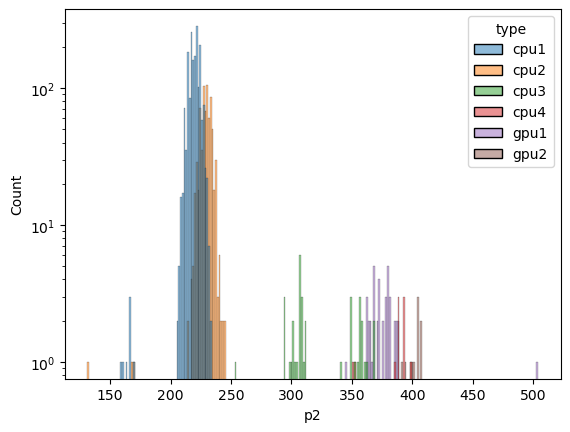

/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


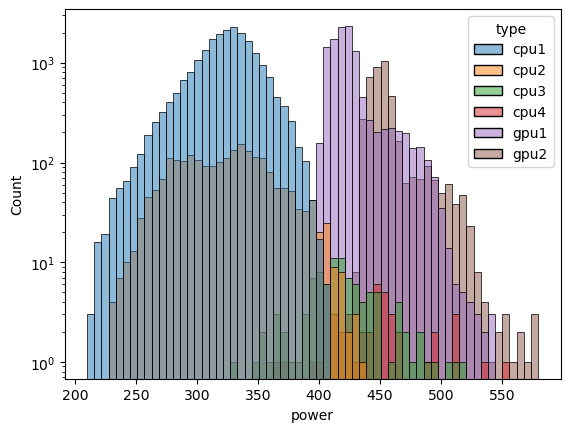

/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


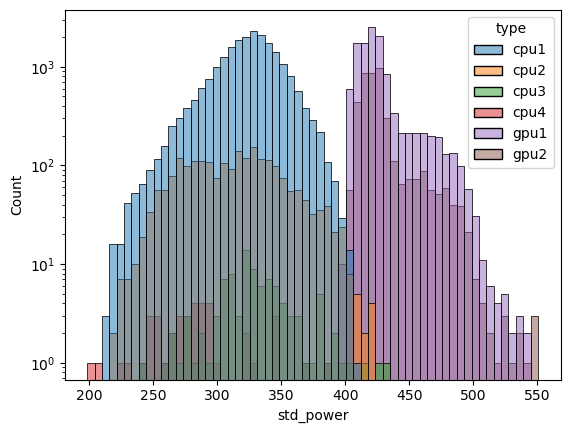

/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


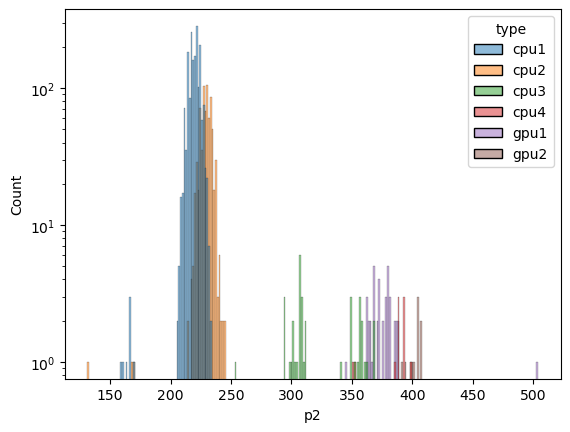

/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


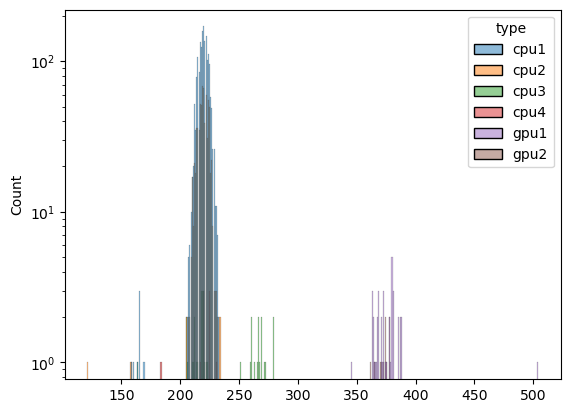

In [8]:
sns.histplot(
    data=node_data, x="p2", hue="type", hue_order=sorted(node_data["type"].unique())
)
plt.yscale("log")
plt.show()
node_data["p2_median_for_type"] = node_data.groupby("type")["p2"].transform(
    lambda x: x.median()
)
node_data["p2_delta_for_type"] = node_data["p2_median_for_type"] - node_data["p2"]
node_data["p2_median_for_class"] = node_data.groupby("has_gpu")["p2"].transform(
    lambda x: x.median()
)
node_data["p2_type_class_delta"] = (
    node_data["p2_median_for_class"] - node_data["p2_median_for_type"]
)
# node_data['p2_node_to_class_delta'] = node_data['p2_median_for_class'] - node_data['p2_median_for_type']

sns.histplot(
    data=runs,
    x="power",
    hue="type",
    hue_order=sorted(node_data["type"].unique()),
)
plt.yscale("log")
plt.show()


sns.histplot(
    data=runs,
    x="std_power",
    hue="type",
    hue_order=sorted(node_data["type"].unique()),
)
plt.yscale("log")
plt.show()


sns.histplot(
    data=node_data,
    x="p2",
    hue="type",
    hue_order=sorted(node_data["type"].unique()),
)
plt.yscale("log")
plt.show()

sns.histplot(
    data=node_data,
    x=node_data["p2"] + node_data["power_offset"],
    hue="type",
    hue_order=sorted(node_data["type"].unique()),
)
plt.yscale("log")
plt.show()
# plt.hist(node_data['p2'], bins=100, color=node_data['type'])

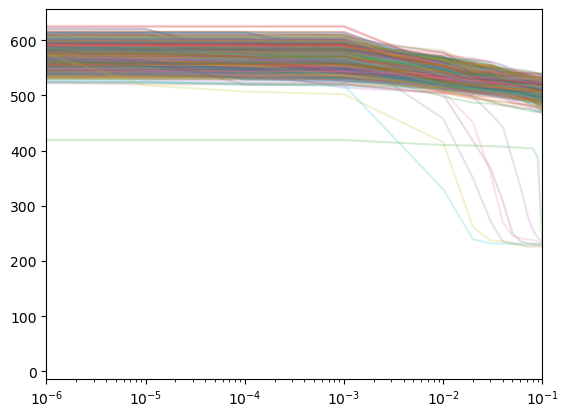

In [9]:
quantile_data = (
    [("p000001", 0.000001), ("p00001", 0.00001), ("p0001", 0.0001), ("p001", 0.001)]
    + [(f"p{i}", i / 100.0) for i in range(1, 100)]
    + [("p999", 0.999), ("p9999", 0.9999), ("p99999", 0.99999), ("p999999", 0.999999)]
)
quantiles = np.array([q for col, q in quantile_data], dtype=np.float64)
quantile_keys = [col for col, q in quantile_data]

# plt.figure(figzise=(10,10))
for node, row in node_data.query('type == "cpu1"').iterrows():
    power_dist = np.array([row[col] for col, q in quantile_data])
    plt.plot(1.0 - quantiles, power_dist, alpha=0.2)
plt.xscale("log")
plt.xlim(1.0 - 0.999999, 0.1)

plt.show()

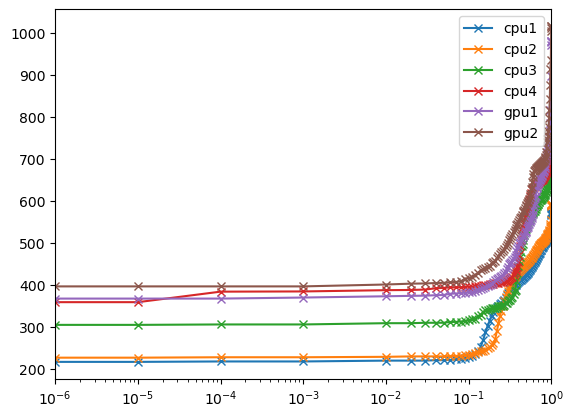

In [10]:
type_groups = node_data.groupby("type")[quantile_keys].median()
for node_type, row in type_groups.iterrows():
    power_dist = np.array([row[col] for col, q in quantile_data])
    plt.plot(quantiles, power_dist, label=node_type, marker="x")
plt.xlim(1e-6, 1)
plt.xscale("log")
plt.legend()
plt.show()

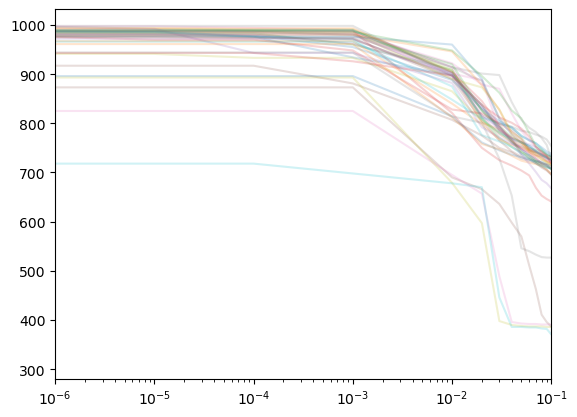

In [11]:
quantile_data = (
    [("p000001", 0.000001), ("p00001", 0.00001), ("p0001", 0.0001), ("p001", 0.001)]
    + [(f"p{i}", i / 100.0) for i in range(1, 100)]
    + [("p999", 0.999), ("p9999", 0.9999), ("p99999", 0.99999), ("p999999", 0.999999)]
)
quantiles = np.array([q for col, q in quantile_data], dtype=np.float64)
quantile_keys = [col for col, q in quantile_data]

# plt.figure(figzise=(10,10))
for node, row in node_data.query('type == "gpu1"').iterrows():
    power_dist = np.array([row[col] for col, q in quantile_data])
    plt.plot(1.0 - quantiles, power_dist, alpha=0.2)
plt.xscale("log")
plt.xlim(1.0 - 0.999999, 0.1)

plt.show()

In [12]:
types = sorted(node_data["type"].unique())


def compute_offsets(key):
    return np.fromiter(
        (node_data.loc[node_data["type"] == type, key].median() for type in types),
        dtype=np.float64,
    )


for key in [
    "p000001",
    "p00001",
    "p0001",
    "p001",
    "p1",
    "p2",
    "p3",
    "p4",
    "p5",
    "p6",
    "p7",
]:
    offsets = compute_offsets(key)
    print(key, offsets)

p000001 [217.  227.  305.  359.  367.5 396.5]
p00001 [217.  227.  305.  359.  367.5 396.5]
p0001 [218.  228.  306.  384.  367.5 396.5]
p001 [218.  228.  306.  384.5 370.  396.5]
p1 [220.  229.  309.  387.5 373.  401. ]
p2 [220. 230. 309. 388. 374. 403.]
p3 [220.  230.  310.  389.  374.5 403.5]
p4 [221.  230.  310.  392.  375.5 404.5]
p5 [221. 230. 310. 393. 376. 405.]
p6 [222.  231.  312.  394.  379.  406.5]
p7 [223.  231.  312.  394.  379.5 407. ]


/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


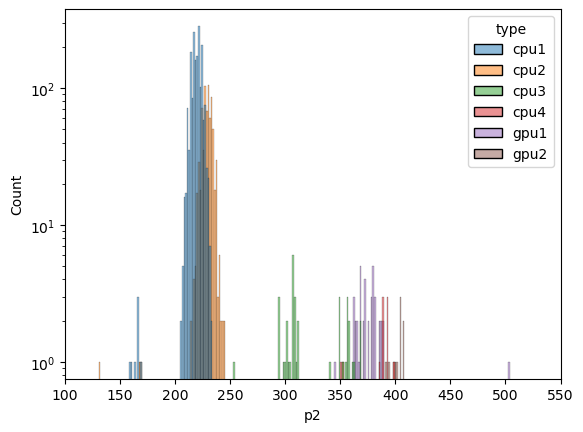

/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(100.0, 550.0)

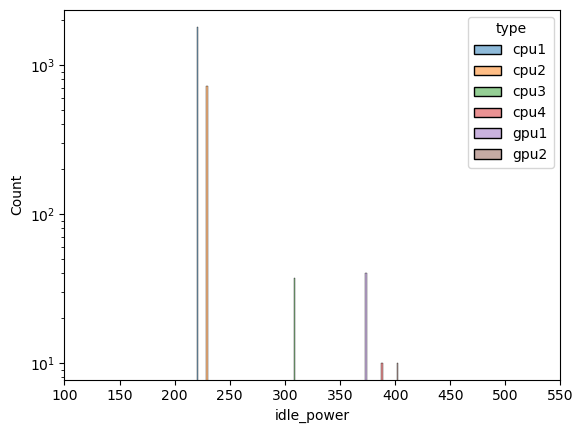

In [13]:
sns.histplot(
    data=node_data,
    x=node_data["p2"],
    hue="type",
    hue_order=sorted(node_data["type"].unique()),
)
plt.yscale("log")
plt.xlim(100, 550)
plt.show()

sns.histplot(
    data=node_data,
    x=node_data["idle_power"],
    hue="type",
    hue_order=sorted(node_data["type"].unique()),
)
plt.yscale("log")
plt.xlim(100, 550)

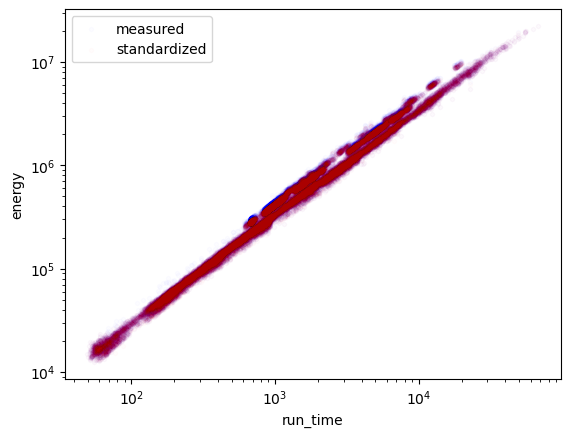

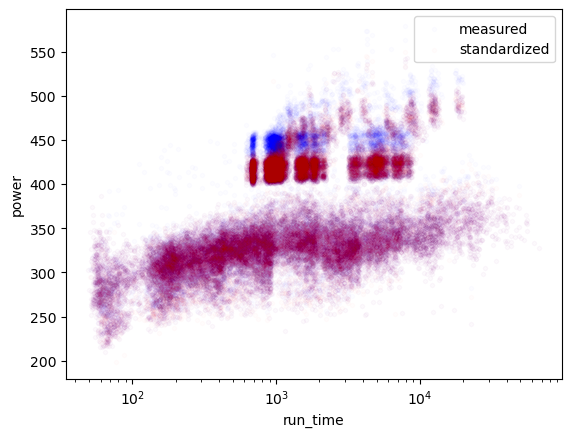

In [16]:
plt.scatter(runs["run_time"], runs["energy"], marker=".", color="blue", alpha=0.01)
plt.scatter(runs["run_time"], runs["std_energy"], marker=".", color="red", alpha=0.01)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("energy")
plt.xlabel("run_time")
plt.legend(["measured", "standardized"])
plt.show()

plt.scatter(runs["run_time"], runs["power"], marker=".", color="blue", alpha=0.01)
plt.scatter(runs["run_time"], runs["std_power"], marker=".", color="red", alpha=0.01)
plt.legend(["measured", "standardized"])
plt.ylabel("power")
plt.xlabel("run_time")
plt.xscale("log")
plt.show()

In [17]:
tecator_low_complexity_runs = runs.loc[
    (runs["dataset"] == "505_tecator") & (runs["size"] <= 2**10)
].groupby("has_gpu")
energy_overhead = tecator_low_complexity_runs["std_energy"].quantile(0.05)
print(f"Estimated experiment overhead energy: {energy_overhead}")
energy_overhead.name = "energy_overhead"
runs = runs.merge(energy_overhead, left_on="has_gpu", right_index=True)
runs["non_overhead_energy"] = runs["std_energy"] - runs["energy_overhead"]
runs = runs.loc[runs["non_overhead_energy"] > 0]

runtime_overhead = tecator_low_complexity_runs["run_time"].quantile(0.05)
runtime_overhead.name = "runtime_overhead"
print(f"Estimated experiment overhead run time: {runtime_overhead}")
runs = runs.merge(runtime_overhead, left_on="has_gpu", right_index=True)
runs["non_overhead_runtime"] = runs["run_time"] - runs["runtime_overhead"]
runs = runs.loc[runs["non_overhead_runtime"] > 0]


# Filter out 505_tecator
runs = runs.loc[runs["dataset"] != "505_tecator"]

Estimated experiment overhead energy: has_gpu
False     14028.665573
True     271560.240048
Name: std_energy, dtype: float64
Estimated experiment overhead run time: has_gpu
False     52.883914
True     656.373676
Name: runtime_overhead, dtype: float64


In [18]:
runs_trimmed = runs.copy()
for column in (set(node_data.columns) - {"node"}).intersection(set(runs.columns)):
    del runs_trimmed[column]


print(runs_trimmed.columns.to_list())
print(node_data.columns.to_list())
# runs.merge(node_data, on='node', how='left')

['run_id', 'experiment_id', 'slurm_job_id', 'start_time', 'update_time', 'end_time', 'node', 'size', 'depth', 'shape', 'dataset', 'learning_rate', 'batch_size', 'optimizer', 'is_gpu', 'batch', 'energy', 'run_time', 'filter_1', 'filter_2', 'filter_3', 'filter_3_stdevs', 'filter', 'start_time_int', 'start_offset', 'power', 'num_reps', 'std_power', 'std_energy', 'energy_overhead', 'non_overhead_energy', 'runtime_overhead', 'non_overhead_runtime']
['CPUS', 'MEMORY', 'TMP_DISK', 'GRES', 'type', 'has_gpu', 'count', 'min', 'p000001', 'p00001', 'p0001', 'p001', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', '

type
cpu1    220.0
cpu2    230.0
cpu3    310.0
cpu4    393.0
gpu1    376.0
gpu2    404.0
Name: p2, dtype: float64
type
cpu1    327.177433
cpu2    328.193303
cpu3    418.483814
cpu4    450.089533
gpu1    422.000950
gpu2    452.336459
Name: power, dtype: float64
type
cpu1    326.310157
cpu2    327.064835
cpu3    425.579536
cpu4    457.145491
gpu1    427.139602
gpu2    457.099363
Name: power, dtype: float64
type
cpu1    327.177433
cpu2    318.193303
cpu3    329.483814
cpu4    282.089533
gpu1    422.000950
gpu2    423.336459
Name: std_power, dtype: float64
type
cpu1    333.575295
cpu2    324.685892
cpu3    338.274018
cpu4    283.812132
gpu1    429.064830
gpu2    430.849005
Name: non_overhead_power, dtype: float64


/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


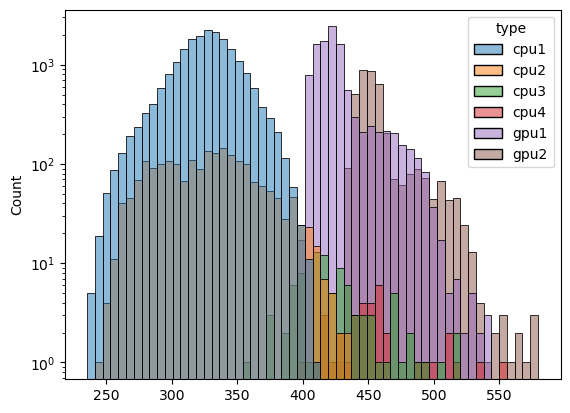

/home/ctripp/gcomp/env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


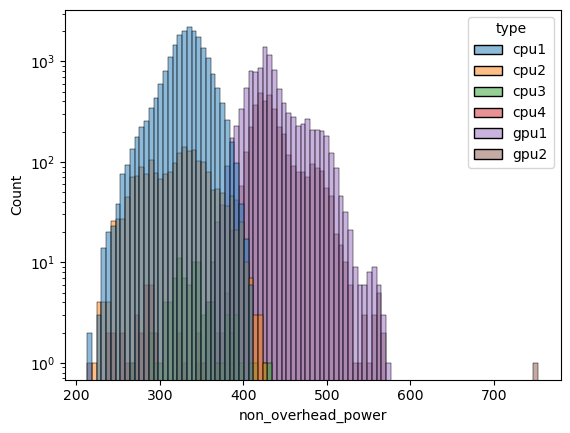

In [21]:
import seaborn as sns

# runs['power'] = runs['energy'] / runs['run_time']
# runs['std_power'] = runs['std_energy'] / runs['run_time']
runs["non_overhead_power"] = runs["non_overhead_energy"] / runs["non_overhead_runtime"]

print(runs.groupby("type")["p2"].quantile(0.5))
print(runs.groupby("type")["power"].quantile(0.5))
print(runs.groupby("type")["power"].mean())
print(runs.groupby("type")["std_power"].quantile(0.5))
print(runs.groupby("type")["non_overhead_power"].quantile(0.5))

sns.histplot(
    data=runs,
    x=runs["energy"] / runs["run_time"],
    hue="type",
    hue_order=sorted(runs["type"].unique()),
)
plt.yscale("log")
plt.show()

sns.histplot(
    data=runs,
    # x=runs['non_overhead_energy'] / runs['non_overhead_runtime'],
    x=runs["non_overhead_power"],
    hue="type",
    hue_order=sorted(runs["type"].unique()),
)
plt.yscale("log")
plt.show()

In [22]:
runs_trimmed.to_csv("data_artifacts/runs_with_standardized_energy.csv")
node_data.to_csv("data_artifacts/nodes_with_standardized_energy.csv")

In [23]:
runs_trimmed.to_csv("data_outputs/runs_with_standardized_energy.csv")

In [24]:
node_data.head(10)

,CPUS,MEMORY,TMP_DISK,GRES,type,has_gpu,count,min,p000001,p00001,p0001,p001,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54,p55,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65,p66,p67,p68,p69,p70,p71,p72,p73,p74,p75,p76,p77,p78,p79,p80,p81,p82,p83,p84,p85,p86,p87,p88,p89,p90,p91,p92,p93,p94,p95,p96,p97,p98,p99,p999,p9999,p99999,p999999,max,p2_median_power,p2_delta_power,median_idle_power_for_type,idle_power,type_median_power,power_offset,p2_median_for_type,p2_delta_for_type,p2_median_for_class,p2_type_class_delta
node,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
r9i0n25,36,180224,900000,(null),cpu2,False,248793.0,145.0,235.0,235.0,235.0,235.0,235.0,235.0,236.0,236.0,237.0,237.0,237.0,237.0,239.0,240.0,245.0,247.0,249.0,250.0,251.0,254.0,261.0,265.0,276.0,290.0,315.0,343.0,349.0,357.0,360.0,371.0,385.0,391.0,407.0,412.0,424.0,434.0,440.0,446.0,450.0,450.0,452.0,453.0,454.0,455.0,455.0,457.0,458.0,461.0,463.0,464.0,466.0,469.0,470.0,472.0,473.0,476.0,479.0,480.0,482.0,488.0,490.0,493.0,494.0,495.0,495.0,496.0,497.0,498.0,499.0,500.0,501.0,501.0,502.0,503.0,503.0,504.0,505.0,506.0,507.0,508.0,508.0,509.0,509.0,510.0,510.0,512.0,513.0,513.0,515.0,517.0,517.0,519.0,520.0,521.0,524.0,526.0,528.0,531.0,532.0,535.0,538.0,542.0,547.0,593.0,593.0,593.0,593.0,601.0,222.0,-13.0,230.0,230.0,230.0,-10.0,230.0,-5.0,222.0,-8.0
r1i6n0,36,85248,900000,(null),cpu1,False,248732.0,131.0,131.0,131.0,131.0,131.0,224.0,224.0,225.0,225.0,225.0,225.0,225.0,225.0,226.0,226.0,226.0,226.0,226.0,226.0,226.0,227.0,227.0,227.0,228.0,229.0,235.0,239.0,247.0,260.0,306.0,350.0,356.0,366.0,366.0,367.0,371.0,385.0,395.0,399.0,401.0,404.0,406.0,408.0,411.0,413.0,415.0,418.0,419.0,420.0,423.0,424.0,426.0,427.0,429.0,431.0,432.0,433.0,434.0,435.0,436.0,437.0,438.0,439.0,441.0,442.0,445.0,449.0,451.0,455.0,457.0,460.0,466.0,469.0,472.0,474.0,475.0,476.0,477.0,478.0,480.0,485.0,493.0,494.0,496.0,497.0,498.0,498.0,500.0,502.0,504.0,505.0,506.0,507.0,508.0,509.0,510.0,511.0,512.0,516.0,517.0,534.0,546.0,549.0,552.0,594.0,594.0,594.0,594.0,602.0,222.0,-2.0,220.0,220.0,220.0,0.0,220.0,-4.0,222.0,2.0
r102u25,36,751616,1500000,(null),cpu3,False,249110.0,300.0,301.0,301.0,301.0,301.0,349.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,351.0,351.0,351.0,351.0,351.0,352.0,352.0,352.0,353.0,354.0,355.0,356.0,356.0,357.0,357.0,358.0,359.0,359.0,360.0,361.0,361.0,362.0,364.0,365.0,367.0,369.0,372.0,375.0,378.0,387.0,400.0,409.0,422.0,448.0,456.0,460.0,462.0,471.0,489.0,498.0,509.0,522.0,542.0,549.0,560.0,574.0,578.0,583.0,590.0,593.0,595.0,598.0,599.0,600.0,602.0,603.0,604.0,604.0,605.0,605.0,606.0,606.0,607.0,608.0,608.0,609.0,610.0,611.0,612.0,614.0,616.0,618.0,621.0,625.0,628.0,630.0,632.0,634.0,635.0,636.0,637.0,638.0,639.0,642.0,645.0,647.0,649.0,651.0,654.0,655.0,660.0,682.0,682.0,682.0,682.0,704.0,222.0,-128.0,309.0,309.0,309.0,-89.0,309.0,-41.0,222.0,-87.0
r104u25,36,751616,1500000,gpu:v100:2,gpu1,True,248073.0,171.0,383.0,383.0,383.0,383.0,384.0,385.0,386.0,386.0,387.0,387.0,388.0,388.0,388.0,389.0,389.0,390.0,390.0,391.0,395.0,399.0,400.0,403.0,407.0,409.0,411.0,413.0,414.0,417.0,421.0,422.0,424.0,427.0,429.0,430.0,431.0,433.0,436.0,445.0,453.0,459.0,463.0,466.0,468.0,471.0,475.0,478.0,488.0,492.0,497.0,499.0,503.0,511.0,517.0,521.0,524.0,526.0,529.0,531.0,533.0,536.0,538.0,543.0,547.0,551.0,557.0,560.0,561.0,567.0,569.0,574.0,585.0,604.0,626.0,640.0,645.0,651.0,657.0,660.0,662.0,664.0,665.0,666.0,667.0,668.0,670.0,675.0,677.0,685.0,690.0,693.0,694.0,698.0,701.0,707.0,715.0,719.0,723.0,735.0,747.0,761.0,785.0,837.0,898.0,934.0,976.0,981.0,981.0,1002.0,379.5,-5.5,374.0,374.0,374.0,0.0,374.0,-11.0,379.5,5.5
r1i6n9,36,85248,900000,(null),cpu1,False,198479.0,117.0,164.0,164.0,164.0,164.0,211.0,211.0,211.0,211.0,213.0,214.0,215.0,215.0,215.0,215.0,216

In [25]:
experiments = runs_trimmed.copy()
experiments["start_time"] = pd.to_datetime(experiments["start_time"])
experiments["update_time"] = pd.to_datetime(experiments["update_time"])
experiments["run_time"] = (
    experiments["update_time"] - experiments["start_time"]
).dt.total_seconds()

print(f"Total points filtered = {experiments['filter'].sum()}")
experiments = experiments.query("filter!=True")
experiments = experiments[
    [
        "experiment_id",
        # "old_experiment_id",
        "depth",
        "size",
        "shape",
        "dataset",
        "node",
        "run_time",
        "energy",
        "power",
        "std_energy",
        "std_power",
        "energy_overhead",
        "non_overhead_energy",
        "runtime_overhead",
        "non_overhead_runtime",
    ]
]

# Filter out 505_tecator
experiments = experiments.loc[experiments["dataset"] != "505_tecator"]

# Merge with node experiments
experiments = experiments.merge(
    node_data[
        [
            # "node",
            "type",
            "has_gpu",
            "median_idle_power_for_type",
            "idle_power",
            # "idle_power_standardization_offset",
        ]
    ],
    left_on="node",
    right_index=True,
    # on="node",
    how="left",
)

for column, t in [
    ("depth", np.int8),
    # ("experiment_id", np.uint64),
    # ("num_free_parameters", np.uint32),
    # ("num_runs", np.uint8),
    ("size", np.uint32),
    ("experiment_id", np.uint64),
    # ("learning_rate", np.float32),
    # ("batch_size", np.uint16),
    # ("is_gpu", np.uint8),
    ("energy", np.float32),
    ("power", np.float32),
    ("std_power", np.float32),
    ("std_energy", np.float32),
    # ("n_observations", np.uint32),
    # ("n_features", np.uint32),
    ("dataset", str),
    ("shape", str),
    ("energy_overhead", np.float32),
    ("non_overhead_energy", np.float32),
    ("runtime_overhead", np.float32),
    ("non_overhead_runtime", np.float32),
]:
    experiments[column] = experiments[column].astype(t)

index_columns = ["experiment_id", "has_gpu"]
groups = experiments.groupby(index_columns)

from pandas.api.types import is_numeric_dtype

numeric_columns = [
    col
    for col, dtype in zip(experiments.columns, experiments.dtypes)
    if is_numeric_dtype(dtype)
]
non_numeric_columns = list(set(experiments.columns) - set(numeric_columns))

# experiments = groups[numeric_columns].median().join(groups[non_numeric_columns].first())
experiments = groups[numeric_columns].median().join(groups[non_numeric_columns].first())
# experiments["experiment_id"] = experiments["old_experiment_id"].astype(np.uint64)
# del experiments["old_experiment_id"]


# # Merge with dataset metadata
experiments = experiments.merge(
    pd.read_csv("./data_inputs/pmlb.csv"), left_on="dataset", right_on="Dataset"
)
del experiments["Dataset"]


for column, t in [
    ("n_features", np.uint16),
    ("n_observations", np.uint32),
]:
    experiments[column] = experiments[column].astype(t)


experiments["n_classes"] = experiments["n_classes"].fillna(0).astype(np.uint8)
# experiments.reset_index(inplace=True)

# # Join with butter summary
import pyarrow.parquet as pq

butter_summary = pq.read_table(
    "./data_inputs/summary_by_epoch/",
    filters=[
        ["optimizer", "=", "Adam"],
        ["label_noise", "=", 0.0],
        ["momentum", "=", 0.0],
        #'dataset', 'shape',
        ["batch_size", "=", 256],
        ["learning_rate", "=", "0.0001"],
        ["l1", "=", 0.0],
        ["l2", "=", 0.0],
        ["regularizer", "=", "none"],
        ["has_label_noise", "=", "false"],
        ["num_runs", ">=", 3],
    ],
    columns=[
        "depth",
        "experiment_id",
        "num_free_parameters",
        "widths",
        "num_runs",
        "size",
        "task",
        "dataset",
        "shape",
        "batch_size",
        "learning_rate",
        "test_loss_best_quantile_0",
        "epoch",
        "test_loss_best_quantile_25",
        "test_loss_best_quantile_50",
        "test_loss_best_quantile_75",
        "test_loss_best_quantile_100",
    ],
).to_pandas()


butter_summary["num_epochs"] = (
    butter_summary["epoch"].transform(lambda x: max(x)).astype(np.int32)
)
butter_summary = butter_summary.loc[butter_summary["num_epochs"].between(2000, 3010)]
butter_summary["num_epochs"] = 3000
butter_summary["experiment_id"] = butter_summary["experiment_id"].astype(np.uint64)

butter_summary.set_index("experiment_id", inplace=True)
butter_summary.sort_index(inplace=True)

experiments["experiment_id"] = experiments["experiment_id"].astype(np.uint64)
experiments = experiments.merge(
    butter_summary[[c for c in butter_summary.columns if c not in experiments.columns]],
    how="inner",
    left_on="experiment_id",
    right_index=True,
)

del butter_summary

experiments["has_gpu"] = experiments["has_gpu"].astype(bool)
experiments["experiment_id"] = experiments["experiment_id"].astype(np.uint64)

Total points filtered = 0


In [26]:
experiments["full_widths"] = experiments.apply(
    lambda r: [r["n_features"]] + list(r["widths"]), axis=1
)

experiments["num_nodes"] = experiments["full_widths"].apply(lambda widths: sum(widths))
experiments["log_size"] = np.log2(experiments["size"]).astype(np.int8)
experiments["log_parameters"] = np.log2(experiments["num_free_parameters"]).astype(
    np.uint8
)

experiments["batch_size"] = experiments["batch_size"].astype(np.int16)
experiments["learning_rate"] = experiments["learning_rate"].astype(np.float32)

test_split = 0.8
experiments["num_training_batches_per_epoch"] = np.ceil(
    (experiments["n_observations"] * test_split) / experiments["batch_size"]
).astype(np.uint32)

experiments["num_test_batches_per_epoch"] = np.ceil(
    (experiments["n_observations"] * (1.0 - test_split)) / experiments["batch_size"]
).astype(np.uint32)
experiments["num_batches_per_epoch"] = (
    experiments["num_training_batches_per_epoch"]
    + experiments["num_test_batches_per_epoch"]
)


experiments["energy_per_training_batch"] = experiments["non_overhead_energy"] / (
    experiments["num_training_batches_per_epoch"] * experiments["num_epochs"]
)

experiments["energy_per_training_datum"] = (
    experiments["energy_per_training_batch"] / experiments["batch_size"]
)
experiments["log10_energy_per_training_datum"] = np.log10(
    experiments["energy_per_training_datum"]
)

experiments["seconds_per_training_batch"] = experiments["non_overhead_runtime"] / (
    experiments["num_training_batches_per_epoch"] * experiments["num_epochs"]
)
experiments["log10_energy_per_training_batch"] = np.log10(
    experiments["energy_per_training_batch"]
)

experiments["traning_data_per_epoch"] = (
    experiments["num_training_batches_per_epoch"] * experiments["batch_size"]
)
experiments["energy_per_epoch"] = (
    experiments["non_overhead_energy"] / experiments["num_epochs"]
)

experiments["energy_per_training_batch"] = experiments["non_overhead_energy"] / (
    experiments["num_training_batches_per_epoch"] * experiments["num_epochs"]
)

experiments["energy_per_training_datum"] = (
    experiments["energy_per_training_batch"] / experiments["batch_size"]
)

experiments["energy_per_data_per_epochs_per_size"] = (
    experiments["energy_per_training_datum"] / experiments["size"]
)

In [27]:
# compute forward and backward pass operations

# approximate total operations per forward pass
experiments["fwd_operations"] = (
    experiments["full_widths"].transform(
        lambda widths: sum(
            (
                next_width * this_width  # multiply accumulates
                + next_width  # activation function
            )
            for i, (this_width, next_width) in enumerate(zip(widths[:-1], widths[1:]))
        )
    )
    * experiments["batch_size"]
)

experiments["num_nodes"] = experiments["full_widths"].transform(
    lambda widths: sum(widths)
)
experiments["max_width"] = experiments["full_widths"].transform(
    lambda widths: max(widths)
)


# approximate backward propagation operations per backward pass
experiments["bwd_layer_operations"] = experiments["full_widths"].transform(
    lambda widths: sum(
        (
            (2 * next_width)  # compute activation gradients
            + (this_width * next_width)  # parameter gradients
            + (0 if i == 0 else (this_width * next_width))  # input gradients
        )
        for i, (this_width, next_width) in enumerate(zip(widths[:-1], widths[1:]))
    )
)

# approximate gradient reduction operations per backward pass
experiments["bwd_reduce_operations"] = experiments["num_free_parameters"] * (
    1 + experiments["batch_size"]
)

# approximate total operations per backward pass
experiments["bwd_operations"] = (
    experiments["bwd_layer_operations"] * experiments["batch_size"]
    + experiments["bwd_reduce_operations"]
)

In [28]:
experiments["flops_per_epoch"] = (
    experiments["num_training_batches_per_epoch"]
    * (experiments["fwd_operations"] + experiments["bwd_operations"])
    + experiments["num_test_batches_per_epoch"] * experiments["fwd_operations"]
)
experiments["flops_per_training_datum"] = experiments["flops_per_epoch"] / (
    experiments["num_training_batches_per_epoch"] * experiments["batch_size"]
)

In [29]:
# Set some constants
bytes_per_float = 4  # 32-bit single-precision floats

# 2 x Intel® Xeon® Gold 6154 Processor
# L3 Cache	24.75 MB, non-inclusive of L2
# L2 Cache 1MB / Core inclusive of L1
# L1 Cache 32KB D, 32KB I/ Core
num_sockets = 2
cores_per_socket = 18

cpu_total_cores = num_sockets * cores_per_socket

cpu_level_1_bytes_per_core = 32 * 1024
cpu_level_1_bytes_per_socket = cpu_level_1_bytes_per_core * cores_per_socket
cpu_level_1_bytes = cpu_level_1_bytes_per_socket * num_sockets


cpu_level_2_bytes_per_core = 1 * 1024 * 1024
cpu_level_2_bytes_per_socket = cpu_level_2_bytes_per_core * cores_per_socket
cpu_level_2_bytes = cpu_level_2_bytes_per_socket * num_sockets

cpu_level_3_bytes_per_socket = 24.75 * 1024 * 1024
cpu_level_3_bytes = cpu_level_3_bytes_per_socket * num_sockets

cpu_total_cache_bytes_per_socket = (
    cpu_level_2_bytes_per_socket + cpu_level_3_bytes_per_socket
)
cpu_total_cache_bytes = cpu_total_cache_bytes_per_socket * num_sockets

bytes_per_parameter = 4 * (3 + 256)

bytes_per_float = 4  # 32-bit single-precision floats

# 2x V100
#
num_gpus = 2

sms_per_gpu = 84

gpu_total_sms = num_gpus * sms_per_gpu

gpu_level_1_bytes_per_sm = (128 - 16) * 1024
gpu_level_1_bytes_per_gpu = gpu_level_1_bytes_per_sm * sms_per_gpu
gpu_level_1_bytes = gpu_level_1_bytes_per_gpu * num_gpus

gpu_level_2_bytes_per_gpu = 6144 * 1024
gpu_level_2_bytes = gpu_level_2_bytes_per_gpu * num_gpus

gpu_ram_bytes_per_gpu = 16 * (1024**3)
gpu_ram_bytes = gpu_ram_bytes_per_gpu * num_gpus

print(gpu_level_1_bytes / 1024**2)
print(gpu_level_2_bytes / 1024**2)


system_ram_bytes = 96 * 2**30
socket_ram_bytes = system_ram_bytes / num_sockets

cpu_caches = [
    # (0, cpu_register_file_size, cores_per_socket*num_sockets),
    (1, cpu_level_1_bytes_per_core, cores_per_socket * num_sockets),
    (2, cpu_level_2_bytes_per_core, cores_per_socket * num_sockets),
    (3, cpu_level_3_bytes_per_socket, num_sockets),
    # (5, socket_ram_bytes, num_sockets),
    (4, system_ram_bytes, 1),
]

gpu_caches = [
    (1, gpu_level_1_bytes_per_sm, sms_per_gpu * num_gpus),
    (2, gpu_level_2_bytes_per_gpu, num_gpus),
    (3, gpu_ram_bytes_per_gpu, num_gpus),
    # (5, socket_ram_bytes, num_sockets),
    # (6, system_ram_bytes, 1),
]

num_caching_levels = max(len(cpu_caches), len(gpu_caches))

cpu_cache_sizes = [e[1] for e in cpu_caches]
gpu_cache_sizes = [e[1] for e in gpu_caches]

18.375
12.0


In [30]:
experiments["zero"] = 0

experiments["zeros"] = experiments.apply(
    lambda r: np.array(
        [
            0
            for input_width, output_width in zip(
                r["full_widths"][:-1], r["full_widths"][1:]
            )
        ],
        dtype=np.int64,
    ),
    axis=1,
)


def compute_effective_working_set_size(
    has_gpu,
    previously_occupied_size,
    previously_occupied_singular_size,
    previous_effective_size,
    # higher_priority_replicated,
    # higher_priority_distributed,
    replicated,
    distributed,
):
    # total_replicated = higher_priority_replicated + replicated
    # total_distributed = higher_priority_distributed + distributed

    # num_cores = gpu_total_sms if has_gpu else cpu_total_cores
    singular_size = replicated + distributed

    caches = gpu_caches if has_gpu else cpu_caches

    cache_cacpacity = 0
    total_cache_capacity = 0
    for cache_level, cache_size, num_units in caches:
        cache_cacpacity += cache_size
        total_cache_capacity += num_units * cache_size

        if cache_cacpacity <= previously_occupied_size:
            continue

        cached_size = replicated + distributed / num_units
        occupied_size = previously_occupied_size + cached_size
        effective_size = previous_effective_size + cached_size

        if occupied_size <= cache_cacpacity:
            return (
                cache_level,
                cached_size,
                occupied_size,
                singular_size,
                previously_occupied_singular_size + singular_size,
                effective_size,
            )

        previously_occupied_size = cache_cacpacity
        previously_occupied_singular_size = total_cache_capacity


def compute_effective_working_set_size_per_layer(
    has_gpu,
    *args,
):
    return [
        compute_effective_working_set_size(
            has_gpu,
            *a,
        )
        for a in zip(*args)
    ]


# experiments["bwd_pass_working_set"] = bytes_per_float * (experiments["num_nodes"] * (1 + experiments["batch_size"]/2) + experiments["num_free_parameters"] * 2)


# experiments["fwd_pass_working_set"] = experiments["fwd_per_layer_working_set"].apply(lambda r : r.sum()).astype(np.uint32)

working_set_suffixes = [
    "_cache_level",
    "_cached_size",
    "_occupied_size",
    "_singular_size",
    "_singular_occupied_size",
    "_effective_size",
]


def compute_cache_level_sizes(caching_data):
    level_sums = np.zeros(num_caching_levels, dtype=np.uint64)
    for (
        level,
        size,
        occupied,
        singular_size,
        singular_occupied_size,
        effective_size,
    ) in caching_data:
        level_sums[level - 1] += size
    return level_sums


def compute_per_layer_cache_levels_and_sizes(
    experiments,
    working_set_name,
    previous_occupied_cache_bytes,
    previous_occupied_singular_size,
    previous_effective_size,
    # higher_priority_replicated,
    # higher_priority_distributed,
    replicated,
    distributed,
):

    per_layer_working_set_caching_data = experiments.apply(
        lambda r: compute_effective_working_set_size_per_layer(
            r["has_gpu"],
            # r[higher_priority_replicated],
            # r[higher_priority_distributed],
            r[previous_occupied_cache_bytes],
            r[previous_occupied_singular_size],
            r[previous_effective_size],
            r[replicated],
            r[distributed],
        ),
        axis=1,
    )

    for i, suffix in enumerate(working_set_suffixes):
        experiments[f"{working_set_name}{suffix}"] = (
            per_layer_working_set_caching_data.transform(
                lambda r: np.array([x[i] for x in r])
            )
        )

    per_layer_cache_level_sizes = per_layer_working_set_caching_data.apply(
        lambda r: compute_cache_level_sizes(r)
    )

    for i in range(num_caching_levels):
        experiments[f"{working_set_name}_cache_level_{i+1}_size"] = (
            per_layer_cache_level_sizes.apply(lambda r: r[i])
        )
        experiments[f"{working_set_name}_cache_level_{i+1}_cumulative_size"] = (
            per_layer_cache_level_sizes.apply(lambda r: sum((s for s in r[i:])))
        )
        experiments[f"{working_set_name}_cache_level_{i+1}_count"] = experiments[
            f"{working_set_name}_cache_level"
        ].transform(lambda r: sum((1 for s in r if s == i)))
        experiments[f"{working_set_name}_cache_level_{i+1}_cumulative_count"] = (
            experiments[f"{working_set_name}_cache_level"].transform(
                lambda r: sum((1 for s in r if s >= i - 1))
            )
        )

    for suffix in working_set_suffixes:
        experiments[f"{working_set_name}_max{suffix}"] = (
            experiments[f"{working_set_name}{suffix}"]
            .apply(lambda r: np.max(r))
            .astype(np.int64)
        )


def compute_working_set_cache_levels(
    experiments,
    working_set_name,
    # higher_priority_replicated,
    # higher_priority_distributed,
    previously_occupied_size,
    previously_occupied_singular_size,
    previous_effective_size,
    replicated,
    distributed,
):
    working_set_info = experiments.apply(
        lambda r: compute_effective_working_set_size(
            r["has_gpu"],
            # r[higher_priority_replicated],
            # r[higher_priority_distributed],
            r[previously_occupied_size],
            r[previously_occupied_singular_size],
            r[previous_effective_size],
            r[replicated],
            r[distributed],
        ),
        axis=1,
    )

    for i, col in enumerate(working_set_suffixes):
        experiments[f"{working_set_name}{col}"] = working_set_info.transform(
            lambda r: r[i]
        ).astype(np.int64)


## V100 has 64 FP32 cores per SM, Intel OneDNN uses 16 FP32 wide AVX512 instructions and memory layout
# experiments["per_node_width"] = (
#     # experiments["has_gpu"] * 64 + (1 - experiments["has_gpu"]) * 16
#     experiments["has_gpu"] * 128
#     + (1 - experiments["has_gpu"]) * 128
# )

experiments["per_layer_interlayer_working_set_distributed"] = experiments.apply(
    lambda r: bytes_per_float
    * r["batch_size"]
    * np.array(
        [
            input_width + output_width
            for input_width, output_width in zip(
                r["full_widths"][:-1], r["full_widths"][1:]
            )
        ],
        dtype=np.int64,
    ),
    axis=1,
)

compute_per_layer_cache_levels_and_sizes(
    experiments,
    "per_layer_interlayer_working_set",
    "zeros",
    "zeros",
    "zeros",
    "zeros",
    "per_layer_interlayer_working_set_distributed",
)


# cache priority:
# 1. inter-layer unit activations/gradients
# 2. parameters
# 3. for training passes: all unit activations
# 3. parameter gradients (accumulated)
# 4. batch data input/output

experiments["per_layer_interlayer_working_set_max_distributed"] = experiments[
    "per_layer_interlayer_working_set_distributed"
].transform(lambda r: np.max(r))
experiments["fwd_pass_working_set_replicated"] = (
    bytes_per_float * experiments["num_free_parameters"]
)

compute_working_set_cache_levels(
    experiments,
    "fwd_pass_working_set",
    # 'zero',
    # 'per_layer_interlayer_working_set_max_distributed',
    "per_layer_interlayer_working_set_max_occupied_size",
    "per_layer_interlayer_working_set_max_singular_occupied_size",
    "per_layer_interlayer_working_set_max_effective_size",
    "fwd_pass_working_set_replicated",
    "zero",
)

experiments["bwd_pass_working_set_distributed"] = (
    bytes_per_float * experiments["batch_size"] * experiments["num_nodes"]
) - experiments[
    "per_layer_interlayer_working_set_max_distributed"
]  # * (experiments['has_gpu'] == 0)

experiments["bwd_pass_working_set_replicated"] = (
    bytes_per_float * 2 * experiments["num_free_parameters"]
)

compute_working_set_cache_levels(
    experiments,
    "bwd_pass_working_set",
    # 'zero',
    # 'per_layer_interlayer_working_set_max_distributed',
    "per_layer_interlayer_working_set_max_occupied_size",
    "per_layer_interlayer_working_set_max_singular_occupied_size",
    "per_layer_interlayer_working_set_max_effective_size",
    "bwd_pass_working_set_replicated",
    "bwd_pass_working_set_distributed",
)

experiments["bytes_per_datum"] = experiments.apply(
    lambda r: (
        r["n_features"]
        + (
            (r["n_classes"] if r["n_classes"] > 2 else 1)
            if r["task"] == "classification"
            else 1
        )
    )
    * bytes_per_float,
    axis=1,
).astype(np.int32)

experiments["dataset_bytes"] = (
    experiments["n_observations"] * experiments["bytes_per_datum"]
)

experiments["epoch_working_set_higher_distributed"] = (
    experiments["bwd_pass_working_set_distributed"]
    + experiments["per_layer_interlayer_working_set_max_distributed"]
)

compute_working_set_cache_levels(
    experiments,
    "epoch_working_set",
    # 'bwd_pass_working_set_replicated',
    # 'epoch_working_set_higher_distributed',
    "bwd_pass_working_set_occupied_size",
    "bwd_pass_working_set_singular_occupied_size",
    "bwd_pass_working_set_effective_size",
    "zero",
    "dataset_bytes",
)

# experiments["epoch_bytes"] = experiments["dataset_bytes"] + experiments["bwd_pass_working_set_replicated"]
# compute_working_set_cache_levels(
#     experiments,
#     'total_epoch_working_set',
#     # 'bwd_pass_working_set_replicated',
#     # 'epoch_working_set_higher_distributed',
#     'bwd_pass_working_set_occupied_size',
#     "bwd_pass_working_set_singular_occupied_size",
#     'zero',
#     'dataset_bytes',
# )

In [32]:
experiments.to_parquet("./data_artifacts/experiments.pq")